## This notebook requires data files generated by running get_gene_pair_data.ipynb for each gene pair.

In [1]:
import os
import sys
import glob
import tables as pyt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm
import scipy.io as sio
from matplotlib import ticker

from numpy import inf
from matplotlib.ticker import FormatStrFormatter
from sklearn import decomposition
from matplotlib import gridspec

%matplotlib inline  
#%matplotlib widget

### Inputs/Paths

In [2]:
# Raw Data, Corrected full
sim_hdf5_path = os.path.join('outputs', 'simulation_outputs', 'simdata_3_models.h5')

# HDF5 Files, Corrected Full
rna_hdf5_path = os.path.join('/', 'Users', 'camerongallivan', 'Research_Data', 'Briggs_RNA_seq_data', 'Corrected_combined.h5')

In [126]:
# Genes to plot/load
genes_to_load = ["sox2", "t"]       # MLP
#genes_to_load = ['zic1', 'foxc1']   # MLP

#genes_to_load = ["gata5", "pax8"]   # anti-correlated
#genes_to_load = ["lhx1", "pax8"]    # correlated

In [127]:
gene_folder = '{}-{}'.format(*genes_to_load)
data_path = os.path.join('outputs', gene_folder, 'data')
plot_path = os.path.join('outputs', gene_folder, 'plots')

### Plotting Functions

In [128]:
def plot_2d_pca(pca_2d_result, plot_info, save_fig=False, fig_name=None):
    #2D plotting the components
    fig = plt.figure()
    ax = fig.add_subplot(111)
    
    # Creating plot object
    p = ax.scatter(pca_2d_result[:,0], pca_2d_result[:,1], c=plot_info['simdat_color_values'])
    cbar = fig.colorbar(p)

    fig.set_size_inches(plot_info['figshape'])
    ax.set_title(plot_info['title'])
    ax.set_xlabel('pca-one')
    ax.set_ylabel('pca-two')
    if save_fig and fig_name is not None:
        plt.savefig(fig_name, format='png', bbox_inches='tight')
    plt.show()

def plot_2d_pca_3_model(pca_2d_result, plot_info, set_counts, save_fig=False, fig_name=None):
    #2D plotting the components
    fig = plt.figure()
    ax = fig.add_subplot(111)
    
    # Creating plot object
    
    ax.scatter(pca_2d_result[set_counts[2]:set_counts[3],0], pca_2d_result[set_counts[2]:set_counts[3],1], marker='s', c='r')
    ax.scatter(pca_2d_result[set_counts[1]:set_counts[2],0], pca_2d_result[set_counts[1]:set_counts[2],1], marker='X', c='g')
    ax.scatter(pca_2d_result[set_counts[0]:set_counts[1],0], pca_2d_result[set_counts[0]:set_counts[1],1], marker='.', c='b')
    
    fig.set_size_inches(plot_info['figshape'])
    ax.set_title(plot_info['title'])
    ax.set_xlabel('pca-one')
    ax.set_ylabel('pca-two')
    if save_fig and fig_name is not None:
        plt.savefig(fig_name, format='png', bbox_inches='tight')
    plt.show()

def plot_2d_pca_3_model_entropy(pca_2d_result, plot_info, set_counts, save_fig=False, fig_name=None):
    #2D plotting the components
    fig = plt.figure()
    ax = fig.add_subplot(111)
    
    zs = np.concatenate(plot_info['simdat_color_values'][:], axis=0)
    min_, max_ = zs.min(), zs.max()
    #markers = ['.','X','s']
    cbar=None
    # Creating plot object
    for i in range(len(set_counts[1:])):
        if cbar is None:
            s = ax.scatter(pca_2d_result[set_counts[i]:set_counts[i+1],0], pca_2d_result[set_counts[i]:set_counts[i+1],1], c=plot_info['simdat_color_values'][i])
            s.set_clim([min_, max_])
            cbar = fig.colorbar(s)
        else:
            s = ax.scatter(pca_2d_result[set_counts[i]:set_counts[i+1],0], pca_2d_result[set_counts[i]:set_counts[i+1],1], c=plot_info['simdat_color_values'][i])
            s.set_clim([min_, max_])
        
    fig.set_size_inches(plot_info['figshape'])
    ax.set_title(plot_info['title'])
    ax.set_xlabel('pca-one')
    ax.set_ylabel('pca-two')
    if save_fig and fig_name is not None:
        plt.savefig(fig_name, format='png', bbox_inches='tight')
    plt.show()
    
def plot_2d_pca_exp(pca_2d_result, pca_2d_result_2, plot_info, set_counts, save_fig=False, fig_name=None):
    #2D plotting the components
    fig = plt.figure()
    ax = fig.add_subplot(111)
    
    # Creating plot object
    zs = np.concatenate(plot_info['simdat_color_values'][:], axis=0)
    min_, max_ = zs.min(), zs.max()
    
    cbar=None
    # Creating plot object
    for i in range(len(set_counts[1:])):
        if cbar is None:
            s = ax.scatter(pca_2d_result[set_counts[i]:set_counts[i+1],0], pca_2d_result[set_counts[i]:set_counts[i+1],1], c=plot_info['simdat_color_values'][i])
            s.set_clim([min_, max_])
            cbar = fig.colorbar(s)
        else:
            s = ax.scatter(pca_2d_result[set_counts[i]:set_counts[i+1],0], pca_2d_result[set_counts[i]:set_counts[i+1],1], c=plot_info['simdat_color_values'][i])
            s.set_clim([min_, max_])
    
    if 'expdat_color_map' in plot_info.keys():
        p = ax.scatter(pca_2d_result_2[:,0], pca_2d_result_2[:,1], c=list(plot_info['expdat_color_map'].keys()), marker='X', s=140,
                       cmap=cm.get_cmap('plasma', len(plot_info['expdat_color_map'])))
        cbar = fig.colorbar(p, ticks=list(plot_info['expdat_color_map'].keys()))
        cbar.ax.set_yticklabels([plot_info['expdat_color_map'][key] for key in plot_info['expdat_color_map'].keys()])
        
        point_labels = [plot_info['expdat_color_map'][key][6:] for key in plot_info['expdat_color_map'].keys()]
        for i, txt in enumerate(point_labels):
            ax.annotate(txt, (pca_2d_result_2[i,0], pca_2d_result_2[i,1]), xytext=(7, 7), textcoords='offset pixels')

    else:
        p = ax.scatter(pca_2d_result_2[:,0], pca_2d_result_2[:,1], c='k', marker='X', s=140)

    fig.set_size_inches(plot_info['figshape'])
    ax.set_title(plot_info['title'])
    ax.set_xlabel('pca-one')
    ax.set_ylabel('pca-two')
    if save_fig and fig_name is not None:
        plt.savefig(fig_name, format='png', bbox_inches='tight')
    plt.show()

def plot_2d_pca_exp_entropy(pca_2d_result, pca_2d_result_2, plot_info, set_counts, save_fig=False, fig_name=None):
    #2D plotting the components
    fig = plt.figure()
    ax = fig.add_subplot(111)
    
    # Creating plot object
    zs = np.concatenate(plot_info['simdat_color_values'][:], axis=0)
    min_, max_ = zs.min(), zs.max()
    
    cbar=None
    # Creating plot object
    for i in range(len(set_counts[1:])):
        if cbar is None:
            s = ax.scatter(pca_2d_result[set_counts[i]:set_counts[i+1],0], pca_2d_result[set_counts[i]:set_counts[i+1],1], c=plot_info['simdat_color_values'][i])
            s.set_clim([min_, max_])
            cbar = fig.colorbar(s)
        else:
            s = ax.scatter(pca_2d_result[set_counts[i]:set_counts[i+1],0], pca_2d_result[set_counts[i]:set_counts[i+1],1], c=plot_info['simdat_color_values'][i])
            s.set_clim([min_, max_])
    
    if 'expdat_color_map' in plot_info.keys():
        p = ax.scatter(pca_2d_result_2[:,0], pca_2d_result_2[:,1], c=plot_info['expdat_color_map'], marker='X', s=140)
            
    if 'exp_point_labels' in plot_info.keys():    
        point_labels = [plot_info['exp_point_labels'][key][6:] for key in plot_info['exp_point_labels'].keys()]
        for i, txt in enumerate(point_labels):
            ax.annotate(txt, (pca_2d_result_2[i,0], pca_2d_result_2[i,1]), xytext=(7, 7), textcoords='offset pixels')

    else:
        p = ax.scatter(pca_2d_result_2[:,0], pca_2d_result_2[:,1], c='k', marker='X', s=140)

    fig.set_size_inches(plot_info['figshape'])
    ax.set_title(plot_info['title'])
    ax.set_xlabel('pca-one')
    ax.set_ylabel('pca-two')
    if save_fig and fig_name is not None:
        print('here')
        plt.savefig(fig_name, format='png', bbox_inches='tight')
    plt.show()

### Loading simulation data

In [129]:
prob_2ds = []
sim_probvec_entropies = []
sim_prob2d_entropies = []
set_counts = [0, ]

In [130]:
h5file = pyt.open_file(sim_hdf5_path, mode='a')

In [131]:
for i, group in enumerate(h5file.iter_nodes('/')):
    prob_2ds.append(np.asarray(group.prob_2d_vector_array))
    sim_probvec_entropies.append(np.asarray(group.system_probvec_entropies))
    sim_prob2d_entropies.append(np.asarray(group.system_prob2d_entropies))
    set_counts.append(set_counts[i]+len(prob_2ds[i]))
    #print(group._v_attrs.model_name)

dimensions = group._v_attrs.dimensions
X_multidim = np.concatenate(prob_2ds[:], axis=0)

In [132]:
h5file.close()

### Loading select experimental data

In [133]:
def load_selected_expdat(dimensions, option=1, gene_pair=["sox2", "t"]):
    phenotype_count = dimensions[0:2].prod()
    gene_folder = '{}-{}'.format(*gene_pair)
    data_path = os.path.join('outputs', gene_folder, 'data')
    file_extension = '_prob2D.mat'
    
    if option == 1:
        filename_template = 'Stage_{}'
        stage_to_lib_dict = np.load(os.path.join('outputs','stage_to_lib_dict.npy')).item()
        stage_to_lib_dict.pop('Stage_11_NPB')
        data_names = list(stage_to_lib_dict.keys())
        
    elif option == 2:
        filename_template = 'Stage_{}'
        stage_to_lib_dict = np.load(os.path.join('outputs','stage_to_lib_dict.npy')).item()
        data_names = list(stage_to_lib_dict.keys())
        
    elif option == 3:
        filename_template = "Library_{}"
        search_string_tmp = filename_template.split('_')[0]
        filelist_tmp = glob.glob(os.path.join(data_path, search_string_tmp+'*'))
        data_names = [filename_template.format(i) for i in range(1,len(filelist_tmp)+1)]
    else:
        print("Please select a valid option; 1, 2, 3")
        sys.exit()
    
    X_multidim_exp = np.empty((len(data_names), phenotype_count))
    expdat_colorID_dict = {}
    
    for i, name in enumerate(data_names):
        expdat_colorID_dict[i] = name
        prob2D_path = os.path.join(data_path, name+file_extension)
        exp_prob2D = sio.loadmat(prob2D_path)['prob2D']
        
        if exp_prob2D.shape[0] < dimensions[0]:
            exp_prob2D = np.pad(exp_prob2D, ((0,dimensions[0]-exp_prob2D.shape[0]) ,(0,dimensions[1]-exp_prob2D.shape[1])), 'constant', constant_values=[0.])
        elif exp_prob2D.shape[0] > dimensions[0]:
            exp_prob2D = exp_prob2D[0:dimensions[0],0:dimensions[1]]
        exp_prob2D_vector = exp_prob2D.reshape(phenotype_count)
        X_multidim_exp[i] = exp_prob2D_vector.T
        
    return X_multidim_exp, expdat_colorID_dict, data_names

def calculate_array_entropy(array, sigma=1e-30):
    array[array==0] = sigma
    array = array/np.sum(array[:])
    
    entropies=[]
    for row in array:
        entropies.append(np.real(-np.sum(np.multiply(row, np.log(row)))))
    return np.array(entropies)

In [134]:
X_multidim_exp, expdat_colorID_dict, stages = load_selected_expdat(dimensions, option=1, gene_pair=genes_to_load)
expdat_prob2d_entropies = calculate_array_entropy(X_multidim_exp, sigma=1e-6)

### Running 2D PCA and prepping for plots

In [135]:
# Initializing Plot inputs dict
plot_inputs = {}
plot_inputs['figshape'] = (14, 8)

In [136]:
# Normal case: Training with simulation data
pca_2d = decomposition.PCA(n_components=2)
pca_2d_result = pca_2d.fit_transform(X_multidim)
# Applying to expdat
pca_2d_result_exp = pca_2d.transform(X_multidim_exp)

### Plotting PCA

3 Model simulation plot of normal data, colored by model
Explained variation per principle component: [0.97216497 0.02709429]


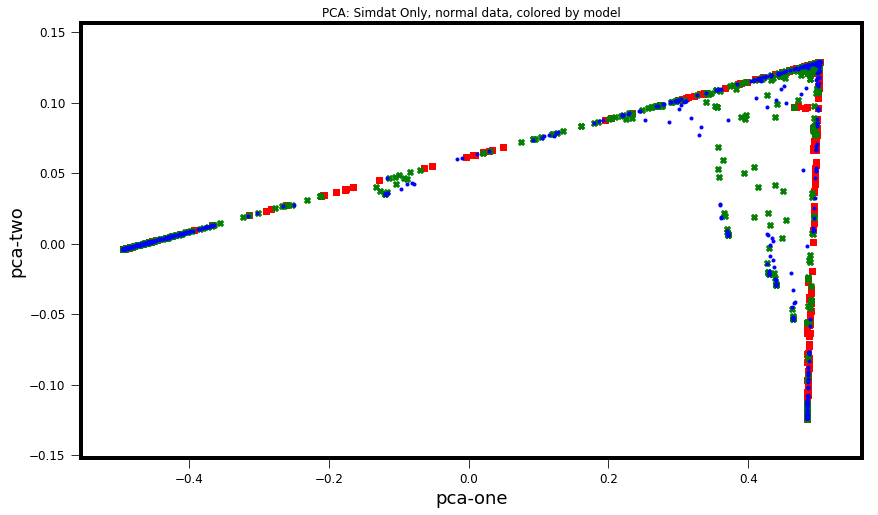

In [137]:
# Plotting just simulation data
print('3 Model simulation plot of normal data, colored by model')
print('Explained variation per principle component: {}'.format(pca_2d.explained_variance_ratio_))

plot_inputs['title']='PCA: Simdat Only, normal data, colored by model'
plot_file_name = 'pca_2d_{}_vs_{}_model_colored.png'.format(*genes_to_load)
plot_2d_pca_3_model(pca_2d_result, plot_inputs, set_counts, save_fig=True, fig_name=os.path.join(plot_path, plot_file_name))

3 Model simulation plot of normal data, colored by ProbVec entropy
Explained variation per principle component: [0.97216497 0.02709429]


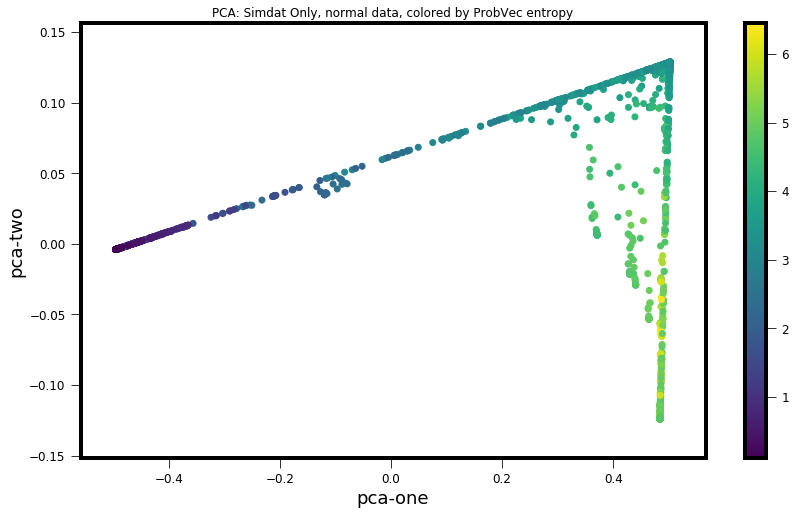

In [138]:
print('3 Model simulation plot of normal data, colored by ProbVec entropy')
print('Explained variation per principle component: {}'.format(pca_2d.explained_variance_ratio_))

plot_inputs['title']='PCA: Simdat Only, normal data, colored by ProbVec entropy'
plot_file_name = 'pca_2d_{}_vs_{}_entropy_colored.png'.format(*genes_to_load)
plot_inputs['simdat_color_values'] = sim_probvec_entropies
plot_2d_pca_3_model_entropy(pca_2d_result, plot_inputs, set_counts, save_fig=True, fig_name=os.path.join(plot_path, plot_file_name))

3 Model simulation plot, with select exp libraries
Explained variation per principle component: [0.97216497 0.02709429]


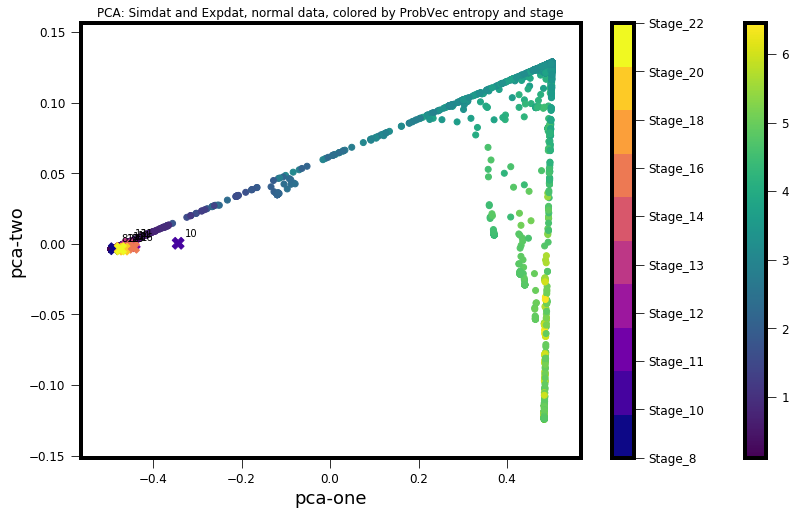

In [139]:
print('3 Model simulation plot, with select exp libraries')
print('Explained variation per principle component: {}'.format(pca_2d.explained_variance_ratio_))

plot_inputs['title']='PCA: Simdat and Expdat, normal data, colored by ProbVec entropy and stage'
plot_file_name = 'pca_2d_{}_vs_{}_all_stages.png'.format(*genes_to_load)
plot_inputs['simdat_color_values'] = sim_probvec_entropies
plot_inputs['expdat_color_map'] = expdat_colorID_dict
plot_2d_pca_exp(pca_2d_result, pca_2d_result_exp, plot_inputs, set_counts, save_fig=True, fig_name=os.path.join(plot_path, plot_file_name))

3 Model simulation plot, with select exp libraries
Explained variation per principle component: [0.97216497 0.02709429]
here


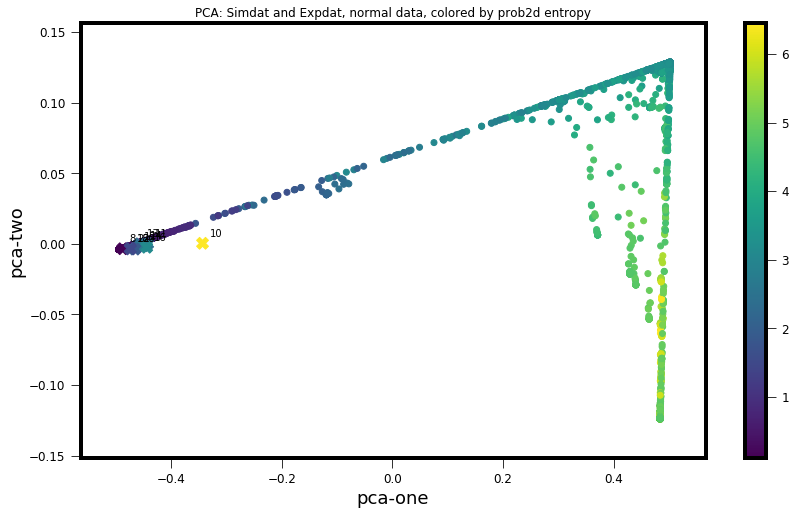

In [140]:
print('3 Model simulation plot, with select exp libraries')
print('Explained variation per principle component: {}'.format(pca_2d.explained_variance_ratio_))

plot_inputs['title']='PCA: Simdat and Expdat, normal data, colored by prob2d entropy'
plot_file_name = 'pca_2d_{}_vs_{}_all_stages_entropy.png'.format(*genes_to_load)
plot_inputs['simdat_color_values'] = sim_probvec_entropies
plot_inputs['expdat_color_map'] = expdat_prob2d_entropies
plot_inputs['exp_point_labels'] = expdat_colorID_dict

plot_2d_pca_exp_entropy(pca_2d_result, pca_2d_result_exp, plot_inputs, set_counts, save_fig=True, fig_name=os.path.join(plot_path, plot_file_name))

### Plotting PCA Component vs Stage

In [141]:
def rcparam():
    plt.rc('axes', linewidth=4.0, labelsize=18)
    # axes and axes labels properties
    plt.rc('xtick.major', size=10)  # length for x
    plt.rc('ytick.major', size=10)  # length for y
    plt.rc('lines', mew=5)
    plt.rc('lines', lw=4)  # line thickness
    plt.rc('ytick', labelsize=12)  # ytick label size
    plt.rc('xtick', labelsize=12)  # xtick label size
    plt.rc('xtick.major', pad=5)  # xtick padding distance
    plt.rc('ytick.major', pad=5)  # ytick padding distance
    
    
def two_subplot_scatter(data, x_axis_data, plot_info={}, save_fig=False, fig_name=None):
    rcparam()
    fig, ax = plt.subplots()
    
    # Figure Creation
    plt.subplot(2, 1, 1)
    plt.plot(x_axis_data, data[:,0], '.-')
    plt.margins(y=0.15)
    ax = plt.gca()
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

    if 'title' in plot_info.keys():
        plt.title(plot_info['title'], fontsize=20, weight='bold', y=1.02)
    if 'y_labels' in plot_info.keys():
        plt.ylabel(plot_info['y_labels'][0])

    plt.subplot(2, 1, 2)
    plt.plot(x_axis_data, data[:,1], '.-')
    plt.margins(y=0.15)
    ax = plt.gca()
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    
    if 'x_label' in plot_info.keys():
        plt.xlabel(plot_info['x_label'])
    if 'y_labels' in plot_info.keys():
        plt.ylabel(plot_info['y_labels'][1])

    plt.subplots_adjust(hspace=0.3, top=1.0)

    if save_fig and fig_name is not None:
        plt.savefig(fig_name, format='png', bbox_inches='tight')
    #plt.close()
    plt.show()

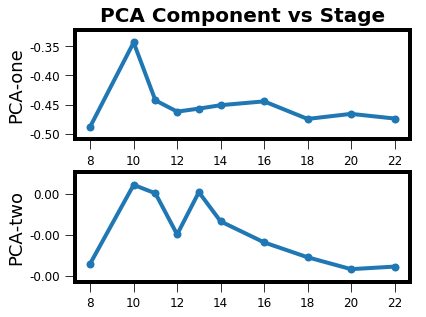

In [142]:
# Creating x axis stage labels 
stage_axis_data = np.array([i[6:] for i in stages], dtype=int)
plot_inputs['title'] = 'PCA Component vs Stage'
plot_inputs['y_labels'] = ['PCA-one', 'PCA-two']
plot_file_name = 'pca_component_vs_stage_{}-{}.png'.format(*genes_to_load)

two_subplot_scatter(pca_2d_result_exp, stage_axis_data, plot_inputs, save_fig=True, fig_name=os.path.join(plot_path, plot_file_name))

### Performing PCA on -log data 
#### (Working but disabled for now because of dependancy on "zero" value)